# Hangman RL

In [37]:
from tqdm import trange
import tensorflow as tf
import numpy as np
from hangman import Environment, Agent

In [38]:
envs = [Environment("dataset.txt") for _ in range(1024)]

In [39]:
agent = Agent(envs[0], batch_size=len(envs), actor_rep=1)

## Training of the main agent

Takes 5/10 minutes depending on the PC

In [40]:
rewards_history = [0]
EPOCHS = 5000
for e in range(EPOCHS):
    print(f"\r{e}/{EPOCHS} - {np.mean(rewards_history[-30:]) or 0}", end="")
    states = []
    masks = []
    # get states and masks for each env
    for env in envs:
        states.append(agent.state(env))
        masks.append(agent.mask(env))
    states = np.array(states)
    masks = np.array(masks)

    # calculate pi(a|s)
    original_probs = agent.actor(states)
    probs = original_probs * masks
    probs = probs / tf.reduce_sum(probs, axis=-1, keepdims=True)
    # sample word to guess
    samples = tf.random.categorical(tf.math.log(probs), 1)[:, 0]

    rewards = []
    dones = []
    # act on each env and collect reward/done
    for sample, env in zip(samples, envs):
        d, r = env.act(agent.int_to_only_letter(env, sample))
        rewards.append(r)
        dones.append(d)

    rewards = np.array(rewards)
    dones = np.array(dones)
    # collect new states, to use for the learning of the agent
    new_states = []
    for env in envs:
        new_states.append(agent.state(env))
    new_states = np.array(new_states)
    # learning for the agent
    agent.learn(states, new_states, samples, rewards, dones, masks)

    # collect history of rewards
    if e > 50: rewards_history.append(np.mean(rewards))


4999/5000 - 0.09430338541666666

## Training of a random agent (baseline)

In [41]:
envs = [Environment("dataset.txt") for _ in range(256)]
shape = (256, len(envs[0].only_letters_list))
random_rewards_history = []
for _ in trange(1000):
    masks = []
    for env in envs:
        masks.append(agent.mask(env))
    masks = np.array(masks)
    # uniform distribution over letters
    probs = np.ones(shape)/shape[-1]
    probs = probs * masks
    probs = probs * tf.linalg.norm(probs, ord=1, axis=-1)[0]
    samples = tf.random.categorical(tf.math.log(probs), 1)[:, 0]
    rewards = []
    for sample, env in zip(samples, envs):
        d,r = env.act(agent.int_to_only_letter(env, sample))
        rewards.append(r)
    rewards = np.array(rewards)
    random_rewards_history.append(np.mean(rewards))

100%|██████████| 1000/1000 [00:21<00:00, 46.47it/s]


## Training results

Text(0.5, 0, 'rewards')

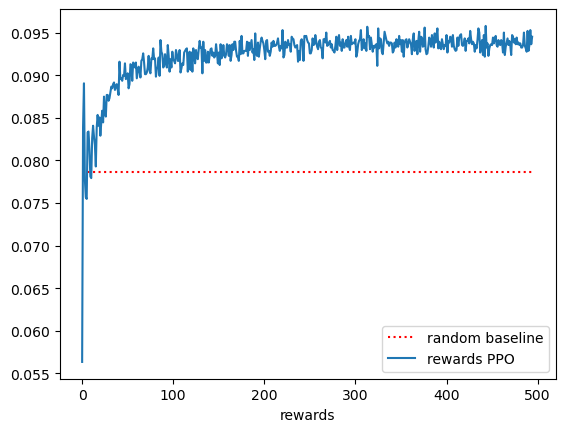

In [43]:
import matplotlib.pyplot as plt
N = 10
rewards_history_ = np.reshape(rewards_history[:len(rewards_history) // N * N], (-1, N)).mean(axis=-1)
plt.hlines(np.mean(random_rewards_history), 0, len(rewards_history_), color="red", linestyles="dotted")
plt.plot(rewards_history_)
plt.legend(["random baseline", "rewards PPO"])
plt.xlabel("epochs")
plt.xlabel("rewards")